In [1]:
########################################
#             PATH SETUP
########################################

import sys
import glob
import os
sys.path.insert(0, os.path.abspath("."))

########################################
#             LIBRERIES SETUP
########################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
from pathlib import Path
from collections.abc import Iterable
from typing import Dict
import seaborn as sns
import math, re
########################################
#             SIMULATION LIBRARIES
########################################
from lemer.rngs import MultiStreamRNG
from lemer.rvms import *
from typing import List, Optional, Tuple
from simulator.simulation import Simulation

In [ ]:

BASE_DIR = ".output_simulation"

# configurazione all'inizio del notebook
OBJ = 2   # scegli 1, 2 o 3

# costruisco dinamicamente il nome del file
config_file = f"obj{OBJ}.json"
config_path = f"analytic_sweep_lambda.csv"
TITLE_PREFIX = f"OBJ{OBJ}"


In [ ]:

def find_csv_for_config(config_path: str, base_dir=BASE_DIR, target="results") -> List[str]:
    cfg_name = Path(config_path).stem
    pattern  = os.path.join(base_dir, f"{target}_{cfg_name}*.csv")
    return sorted(glob.glob(pattern))




def _parse_lambda_from_filename(fname: str) -> Optional[float]:
    base = Path(fname).stem.lower()
    m = re.search(r"(?:lam|lambda|gamma|load)[=_]?([0-9]+(?:\.[0-9]+)?)", base)
    if m: return float(m.group(1))
    # fallback prudente
    for tok in re.findall(r"([0-9]+\.[0-9]+)", base):
        val = float(tok)
        if 0.1 <= val <= 5.0:
            return val
    return None

def load_runs(csv_files: List[str]) -> pd.DataFrame:
    dfs = []
    for i, f in enumerate(csv_files):
        df = pd.read_csv(f)
        df["source"]  = os.path.basename(f)
        df["replica"] = i
        if "arrival_rate" not in df.columns:
            df["arrival_rate"] = _parse_lambda_from_filename(f)
        dfs.append(df)
    if not dfs:
        raise FileNotFoundError("Nessun CSV.")
    df = pd.concat(dfs, ignore_index=True)

    if "mean_response_time" not in df.columns:
        for alt in ("response_time_mean", "rt_mean"):
            if alt in df.columns:
                df = df.rename(columns={alt: "mean_response_time"})
                break
    return df

In [ ]:
conv_files=find_csv_for_config(config_file,target="conv")


In [ ]:



# Trova il CSV analitico a partire dal path della config (come fai per i results)
def find_analytic_csv_for_config(config_path: str, base_dir=BASE_DIR) -> str:
    cfg_name = Path(config_path).stem
    candidates = []
    patterns = [
        os.path.join(base_dir, f"analytic_sweep_{cfg_name}*.csv"),
        os.path.join(base_dir, f"{cfg_name}_analytic*.csv"),
        os.path.join(base_dir, "analytic_sweep_lambda.csv"),
        os.path.join(Path(base_dir).parent, "analytic_sweep_lambda.csv"),
    ]
    for pat in patterns:
        candidates += glob.glob(pat)

    if not candidates:
        raise FileNotFoundError(
            f"Nessun CSV analitico trovato per '{cfg_name}'. "
            f"Cercati pattern: {patterns}"
        )

    candidates.sort(key=lambda p: (len(Path(p).name), p), reverse=True)
    return candidates[0]

# Carica l’analitico nel formato atteso dal plot (colonne: arrival_rate, mean_response_time, X_max opzionale)
def load_analytic_models_for_config(config_path: str, base_dir=BASE_DIR) -> pd.DataFrame:
    path = find_analytic_csv_for_config(config_path, base_dir=base_dir)
    df = pd.read_csv(path)

    # uniforma la colonna lambda → arrival_rate
    if "arrival_rate" not in df.columns and "lambda" in df.columns:
        df = df.rename(columns={"lambda": "arrival_rate"})

    if "arrival_rate" not in df.columns:
        raise ValueError("Il CSV analitico deve contenere almeno 'arrival_rate' o 'lambda'.")

    # ordina per sicurezza
    return df.sort_values("arrival_rate").reset_index(drop=True)


# uso
analytic_df = load_analytic_models_for_config(config_path, base_dir=BASE_DIR)


In [ ]:
files = find_csv_for_config(config_file, base_dir=BASE_DIR)
print("CSV trovati:", len(files))
for f in files: print(" -", f)

In [ ]:


# ---- palette opzionale (riusa PALETTE se definita altrove) ----
def _pal(key, default):
    try:
        return PALETTE[key]  # noqa: F821
    except Exception:
        return default

# ---- banda+linea+CI per la simulazione ----
def _draw_ci_banded(ax, x, mean, half, *, color,
                    label_line="simulation (mean)",
                    label_band="simulation CI band",
                    label_ci="CI 95%",
                    min_display_half=0.0, ci_fill=True):
    x = np.asarray(x, float); mu = np.asarray(mean, float)
    h  = np.maximum(np.asarray(half, float), 0.0)

    if min_display_half > 0:
        h = np.maximum(h, float(min_display_half))

    lo, hi = mu - h, mu + h

    band_patch = None
    if ci_fill:
        ax.fill_between(x, lo, hi, color=color, alpha=0.18, linewidth=0, zorder=2)
        band_patch = mpatches.Patch(color=color, alpha=0.18, label=label_band)

    (line_handle,) = ax.plot(
        x, mu, "o-", color=color, linewidth=2.0, zorder=3,
        markevery=max(1, len(x)//40), label=label_line
    )

    yerr = np.vstack([mu - lo, hi - mu])
    ax.errorbar(x, mu, yerr=yerr, fmt="none",
                ecolor="black", elinewidth=2.4, capsize=6, zorder=4)
    ci_proxy = Line2D([0], [0], color="black", linewidth=2.4, label=label_ci)

    return (line_handle, band_patch, ci_proxy)

# ---- semi-ampiezza CI per OVERALL/NODE_* (usa std intra-run se serve) ----
def _ci_half_from_df(
    df_scope: pd.DataFrame,
    *,
    n_rep: int,
    conf: float,
    ci_design_effect: float,
    mean_col: str = "mean_population",
    std_col: str  = "std_population",
    n_departures_col: str | None = "num_departures",
) -> pd.DataFrame:
    # z 95% default
    def _z_value(c=0.95):
        if abs(c-0.95) < 1e-12: return 1.959963984540054
        lookup = {0.90: 1.6448536269514722, 0.95: 1.959963984540054, 0.975: 2.241402727604947, 0.99: 2.5758293035489004}
        return lookup.get(c, 1.959963984540054)

    z = _z_value(conf)
    df = df_scope.copy()

    for c in ["arrival_rate", mean_col, std_col]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    if n_departures_col and n_departures_col in df.columns:
        df[n_departures_col] = pd.to_numeric(df[n_departures_col], errors="coerce")

    rows_per_lambda = (df.groupby("arrival_rate")[mean_col]
                         .count()
                         .rename("R")
                         .reset_index())

    out_rows = []
    for lam, g in df.groupby("arrival_rate", sort=True):
        R_here = int(rows_per_lambda.loc[rows_per_lambda["arrival_rate"] == lam, "R"].values[0])

        if R_here >= 2:
            m = float(g[mean_col].mean())
            s = float(g[mean_col].std(ddof=1)) if R_here > 1 else 0.0
            half = z * s / math.sqrt(R_here)
        else:
            m = float(g[mean_col].iloc[0])
            std_intra = float(g[std_col].iloc[0]) if (std_col in g.columns and pd.notna(g[std_col].iloc[0])) else 0.0
            if n_departures_col and n_departures_col in g.columns and pd.notna(g[n_departures_col].iloc[0]):
                n_eff = max(1.0, float(g[n_departures_col].iloc[0]) / float(ci_design_effect))
                half  = z * std_intra / math.sqrt(n_eff)
            else:
                half  = z * std_intra * math.sqrt(float(ci_design_effect))

        out_rows.append({"arrival_rate": float(lam), "mean": m, "half": max(0.0, half)})

    return (pd.DataFrame(out_rows)
              .sort_values("arrival_rate")
              .reset_index(drop=True))

# ---- collasso per λ (una sola barra CI a λ) ----
def _collapse_by_lambda(ci_df: pd.DataFrame, how: str = "mean") -> pd.DataFrame:
    if how == "mean":
        agg = {"mean": "mean", "half": "mean"}
    elif how == "max":
        agg = {"mean": "mean", "half": "max"}
    elif how == "min":
        agg = {"mean": "mean", "half": "min"}
    else:
        raise ValueError("how must be 'mean'/'max'/'min'")
    return (ci_df.groupby("arrival_rate", as_index=False)
                 .agg(agg).sort_values("arrival_rate").reset_index(drop=True))

# ---- helper: popolazione analitica per nodo dal CSV ----
def _analytic_node_population(model_df: pd.DataFrame, node: str) -> pd.Series | None:
    """
    Restituisce la serie N_node analitica:
    - Se esiste 'mean_population_{node}', usa quella.
    - Altrimenti se esiste 'util_{node}', calcola N = rho / (1 - rho) con clipping vicino a 1.
    - Altrimenti None.
    """
    # 1) popolazione nodo precomputata?
    col_pop = f"mean_population_{node}"
    if col_pop in model_df.columns:
        return pd.to_numeric(model_df[col_pop], errors="coerce")

    # 2) calcolo da rho (util_node)
    col_rho = f"util_{node}"
    if col_rho in model_df.columns:
        rho = pd.to_numeric(model_df[col_rho], errors="coerce").astype(float)
        # clipping per stabilità numerica vicino a 1
        rho = rho.clip(upper=1.0 - 1e-9)
        with np.errstate(divide="ignore", invalid="ignore"):
            N = rho / (1.0 - rho)
        N[~np.isfinite(N)] = np.nan
        return N

    return None

# ---------------- FUNZIONE PRINCIPALE ----------------
def plot_finite_population_with_analytic(
    files_or_path,
    analytic_df: pd.DataFrame,   # CSV analitico già caricato (tutte le colonne)
    *,
    n_rep: int,
    conf: float = 0.95,
    ci_design_effect: float = 12.0,
    ci_fill: bool = True,
    min_display_half: float = 0.0,
    node_order: list[str] | None = None,
    collapse_how: str = "mean",
    cols: int = 2,
    figsize=(12, 9),
    savepath: str | None = None,
    title: str = "Simulation vs Analytical model — Population",
):
    """
    - Simulazione: media ± CI su SYSTEM e su ogni nodo presente.
    - Analitico (CSV): **solo SYSTEM** da 'mean_population' (rinominato 'SYS').
      Nessun confronto analitico sui singoli nodi.
    """
    # ---- dati simulazione ----
    df = _ensure_df(files_or_path)       # definita in una cella precedente
    detected = _detect_nodes(df)         # definita in una cella precedente
    nodes = ([n for n in (node_order or []) if n in detected] +
             [n for n in detected if not node_order or n not in node_order])

    sys_df  = df[df["vscope"] == "OVERALL"].copy()
    node_df = {n: df[df["vscope"] == f"NODE_{n}"].copy() for n in nodes}

    # CI simulazione
    sys_ci  = _ci_half_from_df(sys_df,  n_rep=n_rep, conf=conf, ci_design_effect=ci_design_effect)
    node_ci = {n: _ci_half_from_df(node_df[n], n_rep=n_rep, conf=conf, ci_design_effect=ci_design_effect)
               for n in nodes}

    # collassa per λ
    sys_ci  = _collapse_by_lambda(sys_ci,  how=collapse_how)
    node_ci = {n: _collapse_by_lambda(d, how=collapse_how) for n, d in node_ci.items()}

    # ---- modello analitico dal CSV (solo SYSTEM) ----
    model = analytic_df.copy()
    if "lambda" in model.columns and "arrival_rate" not in model.columns:
        model = model.rename(columns={"lambda": "arrival_rate"})
    if "mean_population" in model.columns and "SYS" not in model.columns:
        model = model.rename(columns={"mean_population": "SYS"})
    model = model.sort_values("arrival_rate").reset_index(drop=True)

    # ---- layout ----
    n_panels = 1 + len(nodes)
    rows = math.ceil(n_panels / max(1, cols))
    fig, axs = plt.subplots(rows, cols, figsize=figsize, sharex=True)
    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
    fig.suptitle(title, y=0.98)

    col_sim = _pal("SIM", "#ff7f0e")
    col_the = _pal("THEORY", "#1f77b4")

    # ===== SYSTEM (sim vs analitico) =====
    ax = axs[0]
    line_h, band_h, ci_h = _draw_ci_banded(
        ax,
        x=sys_ci["arrival_rate"], mean=sys_ci["mean"], half=sys_ci["half"],
        color=col_sim, label_line="simulation (mean)",
        label_band="simulation CI band", label_ci=f"CI {int(conf*100)}%",
        min_display_half=min_display_half, ci_fill=ci_fill
    )
    handles = [line_h]
    if band_h is not None: handles.append(band_h)
    handles.append(ci_h)

    if "SYS" in model.columns:
        (h_model,) = ax.plot(
            model["arrival_rate"], model["SYS"],
            color=col_the, linewidth=2.3, linestyle="--",
            marker="s", markersize=4, label="analytical model", zorder=6
        )
        handles.append(h_model)

    # X_max (asintoto) se presente
    x_max = None
    if "X_max" in model.columns and pd.notna(model["X_max"].iloc[0]):
        try:
            x_max = float(model["X_max"].iloc[0])
        except Exception:
            x_max = None

    if x_max is not None and np.isfinite(x_max):
        ax.axvline(x_max, linestyle="--", color=col_the, alpha=0.85, linewidth=1.8)
        handles.append(Line2D([0], [0], color=col_the, linestyle="--",
                              label=f"λ* ≈ {x_max:.3g}"))
        ylim_top = ax.get_ylim()[1]
        ax.annotate(f"λ* ≈ {x_max:.3g}",
                    xy=(x_max, ylim_top), xycoords=("data", "data"),
                    xytext=(5, -5), textcoords="offset points",
                    rotation=90, va="top", ha="left",
                    fontsize=10, color=col_the,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.75))
        ax.set_xticks(np.unique(np.append(ax.get_xticks(), x_max)))

    ax.set_title("SYSTEM average population")
    ax.set_xlabel("Lambda"); ax.set_ylabel("Avg population in SYSTEM")
    #ax.set_yscale("log") #per obiettivo 3
    ax.legend(handles=handles, loc="upper left")

    # ===== NODI (solo simulazione) =====
    for i, n in enumerate(nodes, start=1):
        ax = axs[i]
        d = node_ci[n]
        line_h, band_h, ci_h = _draw_ci_banded(
            ax,
            x=d["arrival_rate"], mean=d["mean"], half=d["half"],
            color=col_sim, label_line="simulation (mean)",
            label_band="simulation CI band", label_ci=f"CI {int(conf*100)}%",
            min_display_half=min_display_half, ci_fill=ci_fill
        )
        handles = [line_h]
        if band_h is not None: handles.append(band_h)
        handles.append(ci_h)

        # *** NESSUN confronto analitico per i nodi ***
        # (rimosso il blocco che calcolava/plot-ava N_node)

        ax.set_title(f"{n} average population")
        ax.set_xlabel("Lambda"); ax.set_ylabel(f"Avg population in {n}")
        #ax.set_yscale("log") #per obiettivo 3
        ax.legend(handles=handles, loc="upper left")

    # pannelli extra invisibili
    for j in range(1 + len(nodes), len(axs)):
        axs[j].set_visible(False)
    plt.savefig("pop",dpi=600)
    plt.tight_layout(rect=[0, 0.02, 1, 0.96])
   


In [ ]:


plot_finite_population_with_analytic(
    files_or_path=files,
    analytic_df=analytic_df,      # <-- obbligatorio: usa SEMPRE il CSV analitico che gli passi
    n_rep=5,
    conf=0.95,
    ci_design_effect=12.0,        # fallback solo quando per un λ hai una sola riga
    ci_fill=True,                 # False per togliere la banda arancione
    min_display_half=0.0,
    node_order=["A", "B", "P"],
    collapse_how="mean",          # "max" se vuoi CI più conservativi
    figsize=(12, 9)
    
)

In [ ]:


# --- half-width del CI con nomi di colonna configurabili (solo simulazione) ---
def _ci_half_from_df_generic(
    df_scope: pd.DataFrame,
    *,
    n_rep: int,
    conf: float,
    ci_design_effect: float,
    mean_col: str,
    std_col: str,
    n_departures_col: str | None = "num_departures",
    std_scale: float = 1.0,    # es. 0.001 se std è in ms e la mean in s
) -> pd.DataFrame:
    """
    Ritorna un DF con colonne: arrival_rate, mean, half.
    - Se per un λ ci sono >=2 righe (repliche): usa la varianza *tra repliche* delle MEDIE.
    - Se c'è 1 sola riga: fallback con n_eff = departures / ci_design_effect (>=1).
    """
    z = _z_value(conf)  # <-- già definito sopra

    df = df_scope.copy()
    for c in [mean_col, std_col, "arrival_rate"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    if n_departures_col and n_departures_col in df.columns:
        df[n_departures_col] = pd.to_numeric(df[n_departures_col], errors="coerce")

    rows_per_lambda = (df.groupby("arrival_rate")[mean_col]
                         .count()
                         .rename("R")
                         .reset_index())

    out_rows = []
    for lam, g in df.groupby("arrival_rate", sort=True):
        R_here = int(rows_per_lambda.loc[rows_per_lambda["arrival_rate"] == lam, "R"].values[0])

        if R_here >= 2:
            m = float(g[mean_col].mean())
            s = float(g[mean_col].std(ddof=1)) if R_here > 1 else 0.0
            half = z * s / math.sqrt(R_here)
        else:
            m = float(g[mean_col].iloc[0])
            std_intra = float(g[std_col].iloc[0]) * float(std_scale) if pd.notna(g[std_col].iloc[0]) else 0.0
            if n_departures_col and n_departures_col in g.columns and pd.notna(g[n_departures_col].iloc[0]):
                n_eff = max(1.0, float(g[n_departures_col].iloc[0]) / float(ci_design_effect))
                half = z * std_intra / math.sqrt(n_eff)
            else:
                half = z * std_intra * math.sqrt(float(ci_design_effect))

        out_rows.append({"arrival_rate": float(lam), "mean": m, "half": max(0.0, half)})

    return (pd.DataFrame(out_rows)
              .sort_values("arrival_rate")
              .reset_index(drop=True))


# --- collassa duplicati su λ -> UNA SOLA barra CI per λ ---
def _collapse_by_lambda(ci_df: pd.DataFrame, how: str = "mean") -> pd.DataFrame:
    """Accetta [arrival_rate, mean, half] e collassa per λ."""
    if how == "mean":
        agg = {"mean": "mean", "half": "mean"}
    elif how == "max":
        agg = {"mean": "mean", "half": "max"}
    elif how == "min":
        agg = {"mean": "mean", "half": "min"}
    else:
        raise ValueError("how must be 'mean'/'max'/'min'")
    return (ci_df.groupby("arrival_rate", as_index=False)
                 .agg(agg).sort_values("arrival_rate").reset_index(drop=True))


# --- disegno: banda arancione + linea arancione + barre CI nere ---
def _draw_ci_banded(ax, x, mean, half, *, color,
                    label_line="simulation (mean)",
                    label_band="simulation CI band",
                    label_ci="CI 95%",
                    min_display_half: float = 0.0,
                    ci_fill: bool = True):
    """Ritorna gli handle per la legenda: (line_handle, band_patch, ci_proxy)."""
    x = np.asarray(x, float); mu = np.asarray(mean, float)
    h  = np.maximum(np.asarray(half, float), 0.0)
    if min_display_half > 0:
        h = np.maximum(h, float(min_display_half))
    lo, hi = mu - h, mu + h

    band_patch = None
    if ci_fill:
        ax.fill_between(x, lo, hi, color=color, alpha=0.18, linewidth=0, zorder=2)
        band_patch = mpatches.Patch(color=color, alpha=0.18, label=label_band)

    (line_handle,) = ax.plot(
        x, mu, "o-", color=color, linewidth=2.0, zorder=3,
        markevery=max(1, len(x)//40), label=label_line
    )

    yerr = np.vstack([mu - lo, hi - mu])
    ax.errorbar(x, mu, yerr=yerr, fmt="none",
                ecolor="black", elinewidth=2.4, capsize=6, zorder=4)
    ci_proxy = Line2D([0], [0], color="black", linewidth=2.4, label=label_ci)
    return (line_handle, band_patch, ci_proxy)


# --- PLOT: simulazione (CI) + curva analitica del CSV per SYSTEM ---
def plot_finite_response_time_banded_v3(
    files_or_path,
    analytic_df: pd.DataFrame,            # <-- CSV analitico con 'arrival_rate' e 'mean_response_time'
    *,
    n_rep: int,
    conf: float = 0.95,
    ci_design_effect: float = 12.0,
    ci_fill: bool = True,
    min_display_half: float = 0.0,
    mean_col: str = "mean_response_time",
    std_col: str  = "std_response_time",
    node_order: list[str] | None = None,
    collapse_how: str = "mean",
    cols: int = 2,
    figsize=(12, 9),
    savepath: str | None = None,
    title: str = "Confidence interval for average response time",
    ylabel_unit: str = "s"
):
    # 1) carica DF di simulazione (usa utilità già definite sopra)
    df = _ensure_df(files_or_path)

    # 2) nodi presenti
    detected = _detect_nodes(df)
    nodes = ([n for n in (node_order or []) if n in detected] +
             [n for n in detected if (not node_order or n not in node_order)])

    # 3) split per scope
    df["vscope"] = df["vscope"].astype(str)
    sys_df  = df[df["vscope"] == "OVERALL"].copy()
    node_df = {n: df[df["vscope"] == f"NODE_{n}"].copy() for n in nodes}

    # 4) CI simulazione (SYSTEM + NODI) e collasso per λ
    sys_ci  = _ci_half_from_df_generic(sys_df,  n_rep=n_rep, conf=conf,
                                       ci_design_effect=ci_design_effect,
                                       mean_col=mean_col, std_col=std_col)
    node_ci = {n: _ci_half_from_df_generic(node_df[n], n_rep=n_rep, conf=conf,
                                           ci_design_effect=ci_design_effect,
                                           mean_col=mean_col, std_col=std_col)
               for n in nodes}
    sys_ci  = _collapse_by_lambda(sys_ci,  how=collapse_how)
    node_ci = {n: _collapse_by_lambda(d, how=collapse_how) for n, d in node_ci.items()}

    # 5) modello analitico dal CSV (SOLO SYSTEM)
    model = analytic_df.copy()
    if "lambda" in model.columns:
        model = model.rename(columns={"lambda": "arrival_rate"})
    if "mean_response_time" not in model.columns or "arrival_rate" not in model.columns:
        raise ValueError("analytic_df deve contenere almeno 'arrival_rate' e 'mean_response_time'.")
    model = model.sort_values("arrival_rate").reset_index(drop=True)

    # 6) layout
    n_panels = 1 + len(nodes)
    rows = math.ceil(n_panels / max(1, cols))
    fig, axs = plt.subplots(rows, cols, figsize=figsize, sharex=True)
    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
    fig.suptitle(title, y=0.98)

    col_sim = _pal("SIM",    "#ff7f0e")  # <-- definito sopra
    col_the = _pal("THEORY", "#1f77b4")  # <-- definito sopra

    # --- SYSTEM ---
    ax = axs[0]
    line_h, band_h, ci_h = _draw_ci_banded(
        ax,
        x=sys_ci["arrival_rate"], mean=sys_ci["mean"], half=sys_ci["half"],
        color=col_sim, label_line="simulation (mean)",
        label_band="simulation CI band", label_ci=f"CI {int(conf*100)}%",
        min_display_half=min_display_half, ci_fill=ci_fill
    )
    handles = [line_h] + ([band_h] if band_h is not None else []) + [ci_h]

    (h_model,) = ax.plot(
        model["arrival_rate"], model["mean_response_time"],
        color=col_the, linewidth=2.3, linestyle="--",
        marker="s", markersize=4, label="analytical model", zorder=6
    )
    handles.append(h_model)

    # linea verticale a X_max (se presente)
    # --- X_max (asintoto): linea + voce in legenda + etichetta testuale + tacca su asse X
    Xsat = None
    if "X_max" in model.columns and pd.notna(model["X_max"]).any():
        try:
            Xsat = float(model["X_max"].dropna().iloc[0])
        except Exception:
            Xsat = None

    if Xsat is not None and np.isfinite(Xsat):
        # 1) linea verticale sull'asintoto
        ax.axvline(Xsat, linestyle="--", color=col_the, alpha=0.85, linewidth=1.8)

        # 2) aggiungi una voce alla legenda (proxy handle) nei 'handles' usati sotto
        handles.append(Line2D([0], [0], color=col_the, linestyle="--",
                            label=f"λ* ≈ {Xsat:.3g}"))

        # 3) etichetta verticale vicino alla linea
        ylim_top = ax.get_ylim()[1]
        ax.annotate(f"λ* ≈ {Xsat:.3g}",
                    xy=(Xsat, ylim_top), xycoords=("data", "data"),
                    xytext=(5, -5), textcoords="offset points",
                    rotation=90, va="top", ha="left",
                    fontsize=10, color=col_the,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.75))

        # 4) tacca sull’asse X per leggere subito il valore
        ax.set_xticks(np.unique(np.append(ax.get_xticks(), Xsat)))

        ax.set_title("SYSTEM average response time")
        ax.set_xlabel("Lambda"); ax.set_ylabel(f"Avg response time in SYSTEM [{ylabel_unit}]")
        #ax.set_yscale("log") #per obiettivo 3
        ax.legend(handles=handles, loc="upper left")

    # --- NODI (solo simulazione) ---
    for i, n in enumerate(nodes, start=1):
        ax = axs[i]
        d = node_ci[n]
        line_h, band_h, ci_h = _draw_ci_banded(
            ax,
            x=d["arrival_rate"], mean=d["mean"], half=d["half"],
            color=col_sim, label_line="simulation (mean)",
            label_band="simulation CI band", label_ci=f"CI {int(conf*100)}%",
            min_display_half=min_display_half, ci_fill=ci_fill
        )
        handles = [line_h] + ([band_h] if band_h is not None else []) + [ci_h]
        ax.set_title(f"{n} average response time")
        ax.set_xlabel("Lambda"); ax.set_ylabel(f"Avg response time in {n} [{ylabel_unit}]")
        #ax.set_yscale("log") #per obiettivo 3
        ax.legend(handles=handles, loc="upper left")

    # pannelli extra
    for j in range(1 + len(nodes), len(axs)):
        axs[j].set_visible(False)

    plt.savefig("rt",dpi=600)
    plt.tight_layout(rect=[0, 0.02, 1, 0.96])
    if savepath:
        fig.savefig(savepath, dpi=160, bbox_inches="tight")
    return fig


In [ ]:
# df di simulazione -> 'files' (lista di CSV) o un singolo CSV/DF
# analytic_df -> il CSV analitico già caricato (con 'arrival_rate','mean_response_time', opz. 'X_max')

plot_finite_response_time_banded_v3(
    files_or_path=files,
    analytic_df=analytic_df,
    n_rep=10,
    conf=0.95,
    ci_design_effect=12.0,
    ci_fill=True,
    min_display_half=0.0,
    node_order=["A", "B", "P"],
    collapse_how="mean",
    figsize=(12, 9),
    title="Simulation vs Analytical — Response Time"
)



In [ ]:
def plot_utilization_banded_csv(df_all: pd.DataFrame,
                                analytic_df: pd.DataFrame,
                                *,
                                conf: float = 0.95,
                                ci_design_effect: float = 12.0,
                                ci_fill: bool = True,
                                min_display_half: float = 0.0,
                                node_order: list[str] | None = None,
                                cols: int = 2,
                                figsize=(12, 9),
                                savepath: str | None = None,
                                title: str = "Confidence interval for utilization (sim vs analytical)",
                                y_range: str | tuple[float,float] = "util"):
    if df_all is None or df_all.empty:
        raise ValueError("df_all è vuoto o mancante.")
    if analytic_df is None or analytic_df.empty:
        raise ValueError("analytic_df è vuoto o mancante.")

    dfu = df_all.copy()
    dfu["scope"] = dfu["scope"].astype(str).str.strip().str.upper()

    nodes = sorted([s for s in dfu["scope"].unique() if s != "OVERALL"])
    if node_order:
        nodes = [n for n in node_order if n in nodes] + [n for n in nodes if n not in (node_order or [])]

    # CI simulazione
    ci_over  = _metric_ci(dfu[dfu["scope"]=="OVERALL"], "utilization", conf=conf, ci_design_effect=ci_design_effect)
    ci_nodes = {n: _metric_ci(dfu[dfu["scope"]==n], "utilization", conf=conf, ci_design_effect=ci_design_effect) for n in nodes}

    # modello analitico
    amodel = analytic_df.copy()
    if "lambda" in amodel.columns and "arrival_rate" not in amodel.columns:
        amodel = amodel.rename(columns={"lambda":"arrival_rate"})
    amodel = amodel.sort_values("arrival_rate").reset_index(drop=True)

    over_col = _find_analytic_col(amodel,
                                  overall_aliases=["utilization","system_busy_prob"],
                                  node_alias_fmt_list=[], node_name=None)
    if over_col is None:
        raise ValueError("Nel CSV analitico serve 'utilization' o 'system_busy_prob' per OVERALL.")

    # usa solo λ comuni
    lam_common = np.intersect1d(np.sort(ci_over["x"]), np.sort(amodel["arrival_rate"]))
    amodel = amodel[amodel["arrival_rate"].isin(lam_common)].copy()
    ci_over  = ci_over [ci_over ["x"].isin(lam_common)].copy()
    for n in list(ci_nodes.keys()):
        ci_nodes[n] = ci_nodes[n][ci_nodes[n]["x"].isin(lam_common)].copy()

    # layout
    import math as _m
    n_panels = 1 + len(nodes)
    rows = _m.ceil(n_panels / max(1, cols))
    fig, axs = plt.subplots(rows, cols, figsize=figsize, sharex=True)
    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
    fig.suptitle(title, y=0.98)

    col_sim = _pal("SIM", "#1f77b4")
    col_the = _pal("THEORY", "#ff7f0e")

    # --- preparazione per Y condiviso
    all_y = []
    # overall sim
    all_y += [ci_over["mean"] - ci_over["half"], ci_over["mean"] + ci_over["half"]]
    # overall analytic
    all_y += [amodel[over_col]]
    # nodes
    for n in nodes:
        d = ci_nodes[n]
        all_y += [d["mean"] - d["half"], d["mean"] + d["half"]]
        anal_col = _find_analytic_col(amodel,
                                      overall_aliases=[],
                                      node_alias_fmt_list=[f"util_{{}}", f"UTIL_{{}}"],
                                      node_name=n)
        if anal_col is not None:
            all_y += [amodel[anal_col]]

    clamp = (0.0, 1.0) if y_range == "util" else None
    shared_ylim = _shared_ylim_from_panels(all_y, pad_frac=0.06, clamp=clamp) if y_range in ("shared_auto","util") else (y_range if isinstance(y_range, tuple) else None)

    # --- OVERALL
    ax = axs[0]
    _draw_ci_banded(ax, x=ci_over["x"], mean=ci_over["mean"], half=ci_over["half"],
                    color=col_sim, label_line="simulation (mean)",
                    label_band="simulation CI band", label_ci=f"CI {int(conf*100)}%",
                    min_display_half=min_display_half, ci_fill=ci_fill)
    ax.plot(amodel["arrival_rate"], amodel[over_col],
            color=col_the, linewidth=2.2, linestyle="--", marker="s", markersize=4,
            label="analytical model", zorder=6)
    ax.set_title("SYSTEM utilization")
    ax.set_xlabel("Lambda"); ax.set_ylabel("Utilization"); ax.legend()

    # --- NODI
    for i, n in enumerate(nodes, start=1):
        ax = axs[i]
        d  = ci_nodes[n]
        _draw_ci_banded(ax, x=d["x"], mean=d["mean"], half=d["half"],
                        color=col_sim, label_line="simulation (mean)",
                        label_band="simulation CI band", label_ci=f"CI {int(conf*100)}%",
                        min_display_half=min_display_half, ci_fill=ci_fill)

        anal_col = _find_analytic_col(amodel,
                                      overall_aliases=[],
                                      node_alias_fmt_list=[f"util_{{}}", f"UTIL_{{}}"],
                                      node_name=n)
        if anal_col is not None:
            ax.plot(amodel["arrival_rate"], amodel[anal_col],
                    color=col_the, linewidth=2.2, linestyle="--", marker="s", markersize=4,
                    label="analytical model", zorder=6)
        else:
            ax.text(0.02, 0.92, f"[no 'util_{n[-1]}' in CSV]", transform=ax.transAxes, fontsize=9,
                    ha="left", va="top", color="#888")

        ax.set_title(f"{n} utilization")
        ax.set_xlabel("Lambda"); ax.set_ylabel("Utilization")
        ax.legend()

    # assi extra off
    for j in range(1 + len(nodes), len(axs)):
        axs[j].set_visible(False)

    # griglia + Y condiviso
    for ax in axs:
        if not ax.get_visible(): continue
        ax.grid(True, linestyle="--", alpha=0.35)
        if shared_ylim is not None:
            ax.set_ylim(*shared_ylim)
        ax.tick_params(axis='x', which='both', labelbottom=True)

    plt.tight_layout(rect=[0, 0.02, 1, 0.96])
    if savepath:
        fig.savefig(savepath, dpi=160, bbox_inches="tight")
    return fig


In [ ]:
plot_utilization_banded_csv(df_all, analytic_df, y_range="util", cols=2)

In [ ]:
def plot_throughput_banded_csv(df_all: pd.DataFrame,
                               analytic_df: pd.DataFrame,
                               *,
                               conf: float = 0.95,
                               ci_design_effect: float = 12.0,
                               ci_fill: bool = True,
                               min_display_half: float = 0.0,
                               node_order: list[str] | None = None,
                               cols: int = 2,
                               figsize=(12, 9),
                               savepath: str | None = None,
                               title: str = "Confidence interval for throughput (sim vs analytical)",
                               y_range: str | tuple[float,float] = "shared_auto"):
    if df_all is None or df_all.empty:
        raise ValueError("df_all è vuoto o mancante.")
    if analytic_df is None or analytic_df.empty:
        raise ValueError("analytic_df è vuoto o mancante.")

    dfx = df_all.copy()
    dfx["scope"] = dfx["scope"].astype(str).str.strip().str.upper()

    nodes = sorted([s for s in dfx["scope"].unique() if s != "OVERALL"])
    if node_order:
        nodes = [n for n in node_order if n in nodes] + [n for n in nodes if n not in (node_order or [])]

    # CI simulazione
    ci_over  = _metric_ci(dfx[dfx["scope"]=="OVERALL"], "throughput", conf=conf, ci_design_effect=ci_design_effect)
    ci_nodes = {n: _metric_ci(dfx[dfx["scope"]==n], "throughput", conf=conf, ci_design_effect=ci_design_effect) for n in nodes}

    # analitico
    amodel = analytic_df.copy()
    if "lambda" in amodel.columns and "arrival_rate" not in amodel.columns:
        amodel = amodel.rename(columns={"lambda":"arrival_rate"})
    amodel = amodel.sort_values("arrival_rate").reset_index(drop=True)

    over_col = _find_analytic_col(amodel,
                                  overall_aliases=["throughput","X_total","X","overall_throughput"],
                                  node_alias_fmt_list=[], node_name=None)
    if over_col is None:
        # fallback molto comune: X_overall = arrival_rate
        amodel["__overall_X_fallback__"] = amodel["arrival_rate"]
        over_col = "__overall_X_fallback__"

    lam_common = np.intersect1d(np.sort(ci_over["x"]), np.sort(amodel["arrival_rate"]))
    amodel = amodel[amodel["arrival_rate"].isin(lam_common)].copy()
    ci_over  = ci_over [ci_over ["x"].isin(lam_common)].copy()
    for n in list(ci_nodes.keys()):
        ci_nodes[n] = ci_nodes[n][ci_nodes[n]["x"].isin(lam_common)].copy()

    # layout
    import math as _m
    n_panels = 1 + len(nodes)
    rows = _m.ceil(n_panels / max(1, cols))
    fig, axs = plt.subplots(rows, cols, figsize=figsize, sharex=True)
    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
    fig.suptitle(title, y=0.98)

    col_sim = _pal("SIM", "#1f77b4")
    col_the = _pal("THEORY", "#ff7f0e")

    # Y condiviso
    all_y = [ci_over["mean"]-ci_over["half"], ci_over["mean"]+ci_over["half"], amodel[over_col]]
    for n in nodes:
        d = ci_nodes[n]
        all_y += [d["mean"]-d["half"], d["mean"]+d["half"]]
        anal_col = _find_analytic_col(amodel,
                                      overall_aliases=[],
                                      node_alias_fmt_list=[f"throughput_{{}}", f"X_{{}}"],
                                      node_name=n)
        if anal_col is not None:
            all_y += [amodel[anal_col]]
    shared_ylim = _shared_ylim_from_panels(all_y, pad_frac=0.06) if y_range == "shared_auto" else (y_range if isinstance(y_range, tuple) else None)

    # OVERALL
    ax = axs[0]
    _draw_ci_banded(ax, x=ci_over["x"], mean=ci_over["mean"], half=ci_over["half"],
                    color=col_sim, label_line="simulation (mean)",
                    label_band="simulation CI band", label_ci=f"CI {int(conf*100)}%",
                    min_display_half=min_display_half, ci_fill=ci_fill)
    ax.plot(amodel["arrival_rate"], amodel[over_col],
            color=col_the, linewidth=2.2, linestyle="--", marker="s", markersize=4,
            label="analytical model", zorder=6)
    ax.set_title("SYSTEM throughput")
    ax.set_xlabel("Lambda"); ax.set_ylabel("Throughput"); ax.legend()

    # NODI
    for i, n in enumerate(nodes, start=1):
        ax = axs[i]
        d  = ci_nodes[n]
        _draw_ci_banded(ax, x=d["x"], mean=d["mean"], half=d["half"],
                        color=col_sim, label_line="simulation (mean)",
                        label_band="simulation CI band", label_ci=f"CI {int(conf*100)}%",
                        min_display_half=min_display_half, ci_fill=ci_fill)

        anal_col = _find_analytic_col(amodel,
                                      overall_aliases=[],
                                      node_alias_fmt_list=[f"throughput_{{}}", f"X_{{}}"],
                                      node_name=n)
        if anal_col is not None:
            ax.plot(amodel["arrival_rate"], amodel[anal_col],
                    color=col_the, linewidth=2.2, linestyle="--", marker="s", markersize=4,
                    label="analytical model", zorder=6)
        

        ax.set_title(f"{n} throughput")
        ax.set_xlabel("Lambda"); ax.set_ylabel("Throughput")
        ax.legend()

    for j in range(1 + len(nodes), len(axs)):
        axs[j].set_visible(False)

    for ax in axs:
        if not ax.get_visible(): continue
        ax.grid(True, linestyle="--", alpha=0.35)
        if shared_ylim is not None:
            ax.set_ylim(*shared_ylim)
        ax.tick_params(axis='x', which='both', labelbottom=True)

    plt.tight_layout(rect=[0, 0.02, 1, 0.96])
    if savepath:
        fig.savefig(savepath, dpi=160, bbox_inches="tight")
    return fig


In [ ]:
plot_throughput_banded_csv(df_all, analytic_df, y_range="shared_auto", cols=2)

In [53]:
# === batch_means + plot 2x2 per scope ===
# Commenti SOLO in italiano.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def _crit_value(ci: float, dof: int | None):
    """Ritorna il valore critico per CI.
       Usa t-Student se SciPy è disponibile e dof>=1, altrimenti z."""
    z_map = {0.90: 1.645, 0.95: 1.96, 0.99: 2.576}
    # prova SciPy
    tdist = None
    if dof is not None and dof >= 1:
        try:
            from scipy.stats import t as tdist  # type: ignore
        except Exception:
            tdist = None
    if tdist is not None:
        alpha = 1 - ci
        return float(tdist.ppf(1 - alpha/2, dof))
    # fallback z
    if ci not in z_map:
        raise ValueError("CI non supportata senza SciPy (usa 0.90, 0.95 o 0.99).")
    return z_map[ci]

def batch_means_ci(
    df: pd.DataFrame,
    arrival_col="ARRIVAL_RATE",
    batch_col="BATCH_NUM",
    metrics=("MEAN_RESPONSE_TIME", "MEAN_POPULATION", "THROUGHPUT", "UTILIZATION"),
    ci=0.95,
    ddof=1,
) -> pd.DataFrame:
    """Applica batch means su un singolo subset (es. un valore di SCOPE).
       Ritorna per ogni λ solo <metrica>_mean/lower/upper."""
    # 1) media per batch (gestisce più righe per batch)
    per_batch = (
        df.groupby([arrival_col, batch_col], dropna=False)[list(metrics)]
          .mean()
          .reset_index()
    )

    # 2) aggregazione tra batch per ciascun λ
    def _agg_batches(g: pd.DataFrame) -> pd.Series:
        out = {}
        for m in metrics:
            x = g[m].dropna()
            n = int(x.shape[0])
            if n == 0:
                mean = lower = upper = np.nan
            else:
                mean = float(x.mean())
                se = float(x.std(ddof=ddof) / np.sqrt(n)) if n > 1 else 0.0
                crit = _crit_value(ci, n - 1 if n > 1 else None)
                ci_abs = crit * se
                lower, upper = mean - ci_abs, mean + ci_abs
            out[f"{m}_mean"]  = mean
            out[f"{m}_lower"] = lower
            out[f"{m}_upper"] = upper
        return pd.Series(out)

    res = (
        per_batch.groupby(arrival_col, dropna=False)
                 .apply(_agg_batches)
                 .reset_index()
                 .sort_values(arrival_col)
                 .reset_index(drop=True)
    )
    return res

def batch_means_ci_by_scope(
    df: pd.DataFrame,
    scope_col="SCOPE",
    arrival_col="ARRIVAL_RATE",
    batch_col="BATCH_NUM",
    metrics=("MEAN_RESPONSE_TIME", "MEAN_POPULATION", "THROUGHPUT", "UTILIZATION"),
    ci=0.95,
    ddof=1,
):
    """Calcola batch means separatamente per ogni SCOPE.
       Ritorna una lista di DataFrame (uno per scope), ciascuno con colonne mean/lower/upper."""
    results = []
    for s in df[scope_col].unique():
        sub = df[df[scope_col] == s]
        res = batch_means_ci(
            sub,
            arrival_col=arrival_col,
            batch_col=batch_col,
            metrics=metrics,
            ci=ci,
            ddof=ddof,
        )
        res.insert(0, scope_col, s)
        results.append(res)
    return results

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def _crit_value(ci: float, dof: int | None):
    z_map = {0.90: 1.645, 0.95: 1.96, 0.99: 2.576}
    tdist = None
    if dof is not None and dof >= 1:
        try:
            from scipy.stats import t as tdist
        except Exception:
            tdist = None
    if tdist is not None:
        alpha = 1 - ci
        return float(tdist.ppf(1 - alpha/2, dof))
    if ci not in z_map:
        raise ValueError("CI non supportata senza SciPy (usa 0.90, 0.95 o 0.99).")
    return z_map[ci]

def batch_means_ci(
    df: pd.DataFrame,
    arrival_col="ARRIVAL_RATE",
    batch_col="BATCH_NUM",
    metrics=("MEAN_RESPONSE_TIME", "MEAN_POPULATION", "THROUGHPUT", "UTILIZATION"),
    ci=0.95,
    ddof=1,
):
    per_batch = (
        df.groupby([arrival_col, batch_col], dropna=False)[list(metrics)]
          .mean()
          .reset_index()
    )

    def _agg_batches(g: pd.DataFrame) -> pd.Series:
        out = {}
        for m in metrics:
            x = g[m].dropna()
            n = len(x)
            if n == 0:
                mean = lower = upper = np.nan
            else:
                mean = float(x.mean())
                se = float(x.std(ddof=ddof) / np.sqrt(n)) if n > 1 else 0.0
                crit = _crit_value(ci, n - 1 if n > 1 else None)
                ci_abs = crit * se
                lower, upper = mean - ci_abs, mean + ci_abs
            out[f"{m}_mean"]  = mean
            out[f"{m}_lower"] = lower
            out[f"{m}_upper"] = upper
        return pd.Series(out)

    return (
        per_batch.groupby(arrival_col, dropna=False)
                 .apply(_agg_batches)
                 .reset_index()
                 .sort_values(arrival_col)
                 .reset_index(drop=True)
    )

def batch_means_ci_by_scope(
    df: pd.DataFrame,
    scope_col="SCOPE",
    arrival_col="ARRIVAL_RATE",
    batch_col="BATCH_NUM",
    metrics=("MEAN_RESPONSE_TIME", "MEAN_POPULATION", "THROUGHPUT", "UTILIZATION"),
    ci=0.95,
    ddof=1,
):
    results = []
    for s in df[scope_col].unique():
        sub = df[df[scope_col] == s]
        res = batch_means_ci(sub, arrival_col, batch_col, metrics, ci, ddof)
        res.insert(0, scope_col, s)
        results.append(res)
    return results

def plot_results_list_subplots(
    results: list[pd.DataFrame],
    metrics=("MEAN_RESPONSE_TIME", "MEAN_POPULATION", "THROUGHPUT", "UTILIZATION"),
    scope_col="SCOPE",
    xcol="ARRIVAL_RATE",
    save_dir: str | None = None,
):
    labels = {
        "MEAN_RESPONSE_TIME": "Mean Response Time [s]",
        "MEAN_POPULATION": "Population [N]",
        "THROUGHPUT": "Throughput [job/s]",
        "UTILIZATION": "Utilization",
    }

    for df_scope in results:
        scope_val = str(df_scope.iloc[0][scope_col]) if len(df_scope) else "<unknown>"
        fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
        fig.suptitle(f"{scope_val} — Metrics", fontsize=14)

        for ax, m in zip(axes.flatten(), metrics):
            x = df_scope[xcol].values
            y = df_scope[f"{m}_mean"].values
            lower = df_scope[f"{m}_lower"].values
            upper = df_scope[f"{m}_upper"].values
            yerr = np.vstack([y - lower, upper - y])
            # linea blu
            ax.plot(x, y, '.-', color="orange")
            # barre rosse
            ax.errorbar(x, y, yerr=yerr, fmt='none', ecolor="black", capsize=5)
            
            ax.set_xlabel("λ [job/s]")
            ax.set_ylabel(labels.get(m, m))
            ax.grid(True)

        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        if save_dir:
            import os
            os.makedirs(save_dir, exist_ok=True)
            out = os.path.join(save_dir, f"batchmeans_{scope_val}.png")
            fig.savefig(out, dpi=600)
        plt.show()


# === Overlay di più liste di DataFrame su subplot 2x2 per SCOPE ===
# Commenti SOLO in italiano.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_overlay_subplots(
    list_of_results: list[list[pd.DataFrame]],
    group_labels: list[str] | None = None,
    metrics=("MEAN_RESPONSE_TIME", "MEAN_POPULATION", "THROUGHPUT", "UTILIZATION"),
    scope_col="SCOPE",
    xcol="ARRIVAL_RATE",
    save_dir: str | None = None,
):
    """
    Disegna, per ogni SCOPE, una figura con griglia (2x2) e sovrappone le serie
    provenienti da più liste di DataFrame (ognuna è un “gruppo”/esperimento).

    Parametri:
    - list_of_results: lista di liste. Ogni elemento è la 'results' ritornata da batch_means_ci_by_scope.
      Ciascun DataFrame deve avere colonne:
        [scope_col, xcol, <metrica>_mean, <metrica>_lower, <metrica>_upper] per ogni metrica.
    - group_labels: nomi da usare in legenda, uno per ciascuna lista in list_of_results.
    - metrics: tuple delle 4 metriche in ordine dei subplot.
    - scope_col, xcol: nomi colonne scope e asse X (λ).
    - save_dir: se non None, salva un PNG per ciascun SCOPE.

    Output:
    - Mostra una figura per SCOPE con le 4 metriche sovrapposte per tutti i gruppi.
    """
    # Etichette con unità
    ylabels = {
        "MEAN_RESPONSE_TIME": "Mean Response Time [s]",
        "MEAN_POPULATION":   "Population [N]",
        "THROUGHPUT":        "Throughput [job/s]",
        "UTILIZATION":       "Utilization",
    }
    xlabel = "λ [job/s]"

    # Colori predefiniti per gruppi (coppie: linea, barre)
    # Aggiungine altri se prevedi >6 gruppi
    line_colors = ["blue", "orange", "green", "purple", "brown", "teal"]
    bar_colors  = ["black",  "black", "darkgreen", "indigo", "firebrick", "darkcyan"]
    markers     = [".", ".", "o", "^", "v", "P"]
    linestyles  = ["-", "--", "-.", ":", "-", "--"]

    G = len(list_of_results)
    if group_labels is None:
        group_labels = [f"Group {i+1}" for i in range(G)]
    assert len(group_labels) == G, "group_labels deve avere stessa lunghezza di list_of_results"

    # Raccogli tutti gli scope presenti in almeno un gruppo (unione degli scope)
    all_scopes = []
    for results in list_of_results:
        scopes = [df.iloc[0][scope_col] for df in results if len(df) > 0 and scope_col in df.columns]
        all_scopes.extend(scopes)
    scopes_unique = list(dict.fromkeys(all_scopes))  # preserva ordine di apparizione

    # Mappa metrica -> posizione subplot
    positions = {(0,0): metrics[0], (0,1): metrics[1], (1,0): metrics[2], (1,1): metrics[3]}

    for scope_val in scopes_unique:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
        fig.suptitle(f"SCOPE: {scope_val} — mean ± CI", fontsize=14)

        for gi, results in enumerate(list_of_results):
            # Trova il df relativo a questo scope nel gruppo gi
            df_scope = None
            for df in results:
                if len(df) and scope_col in df.columns and df.iloc[0][scope_col] == scope_val:
                    df_scope = df
                    break
            if df_scope is None:
                continue  # questo gruppo non ha lo scope richiesto

            x = df_scope[xcol].values
            lc = line_colors[gi % len(line_colors)]
            bc = bar_colors[gi % len(bar_colors)]
            mk = markers[gi % len(markers)]
            ls = linestyles[gi % len(linestyles)]

            for (r, c), m in positions.items():
                ax = axes[r, c]
                y = df_scope[f"{m}_mean"].values
                lower = df_scope[f"{m}_lower"].values
                upper = df_scope[f"{m}_upper"].values
                yerr = np.vstack([y - lower, upper - y])

                # curva (linea + marker) con colore dedicato
                ax.plot(x, y, marker=mk, linestyle=ls, color=lc, label=group_labels[gi] if (r, c) == (0,0) else None)
                # barre di confidenza con colore distinto
                ax.errorbar(x, y, yerr=yerr, fmt='none', ecolor=bc, capsize=4)

                ax.set_xlabel(xlabel)
                ax.set_ylabel(ylabels.get(m, m))
                ax.grid(True)

        # legenda nel primo pannello
        axes[0,0].legend(loc="best")
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])

        if save_dir:
            import os
            os.makedirs(save_dir, exist_ok=True)
            out = f"{save_dir}/overlay_{scope_val}.png"
            fig.savefig(out, dpi=150)

        plt.show()

# === ESEMPIO ===
# df = pd.read_csv("obj1_arrivals.csv")
# metrics = ("MEAN_RESPONSE_TIME", "MEAN_POPULATION", "THROUGHPUT", "UTILIZATION")
# results = batch_means_ci_by_scope(df, metrics=metrics, ci=0.95)
# plot_results_list_subplots(results, metrics=metrics, save_dir="plots_batchmeans")

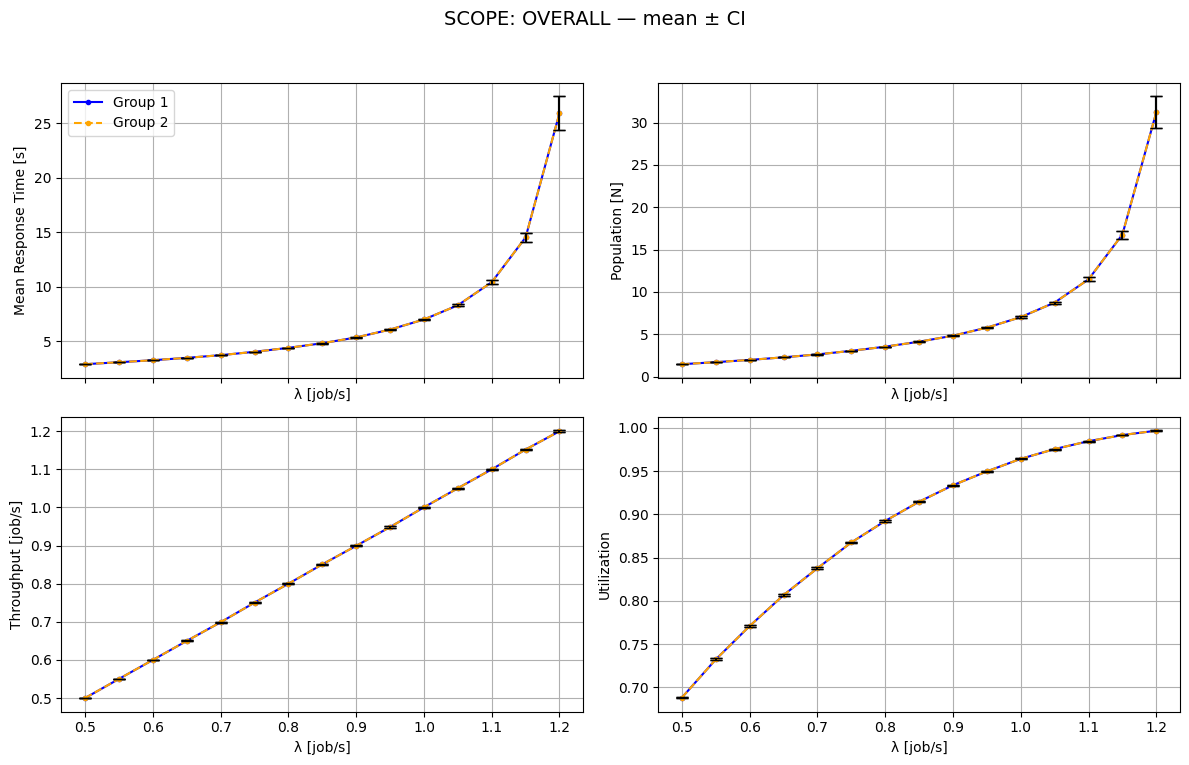

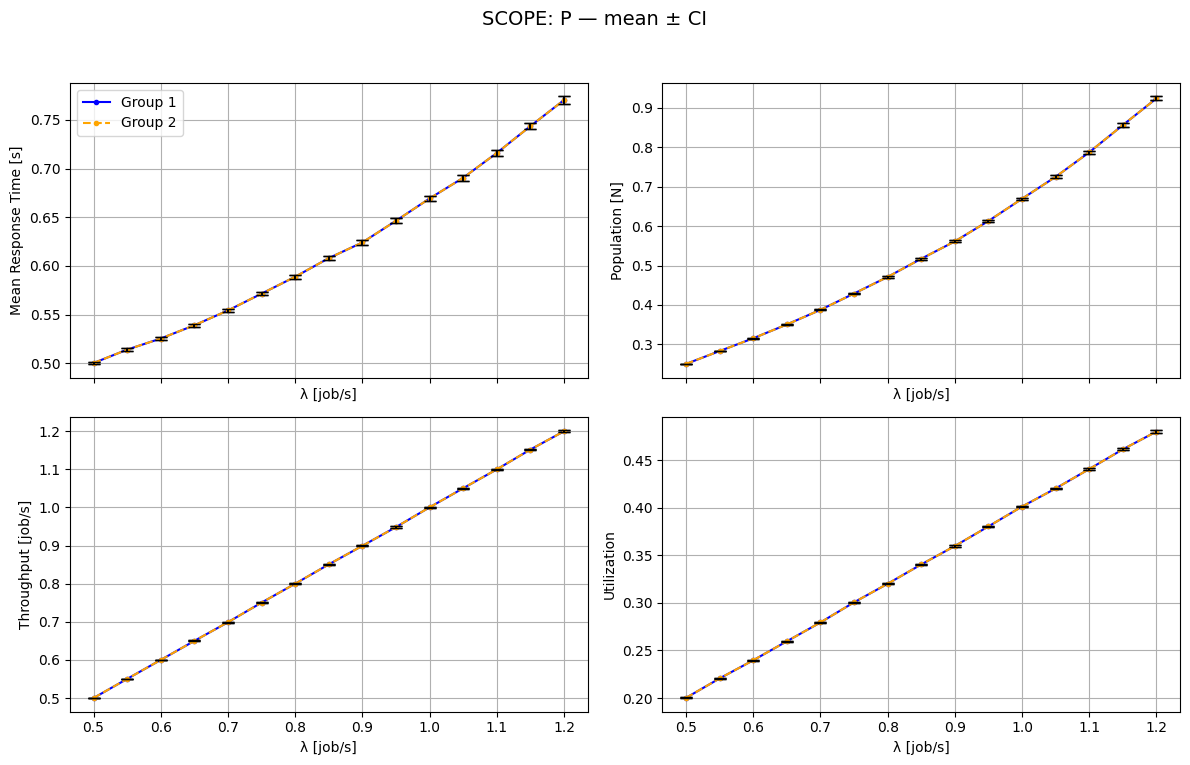

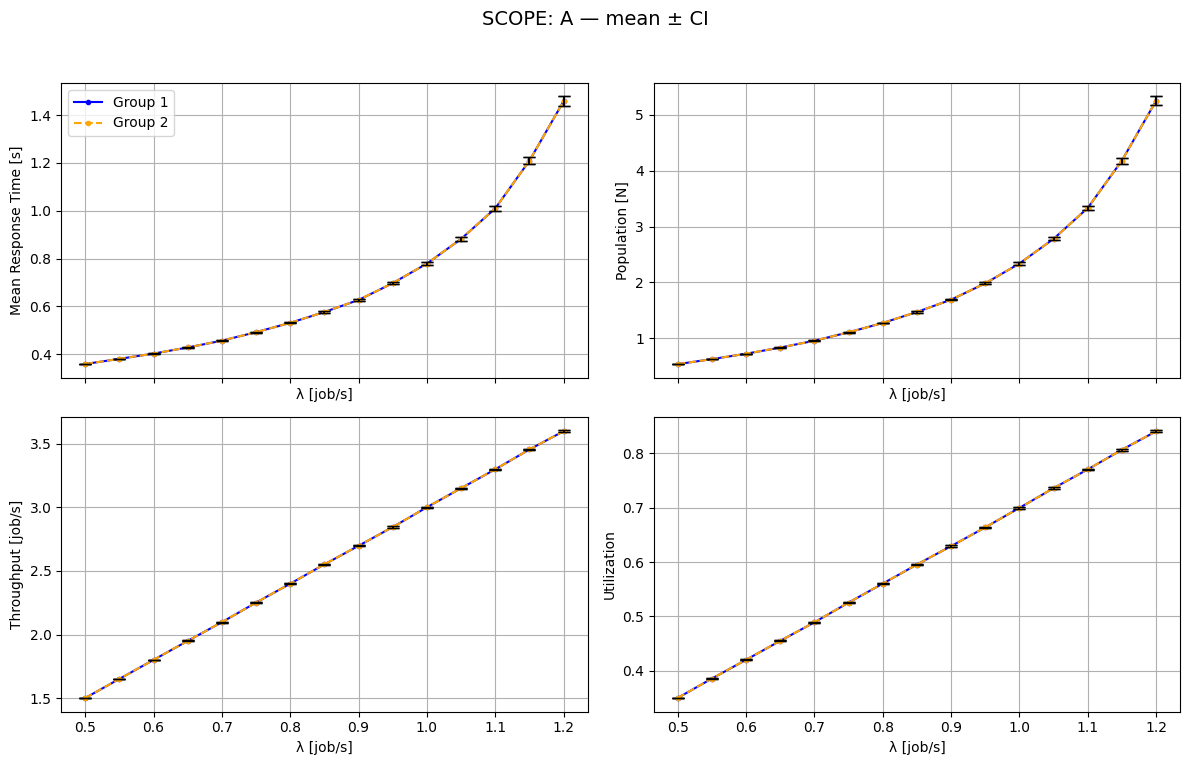

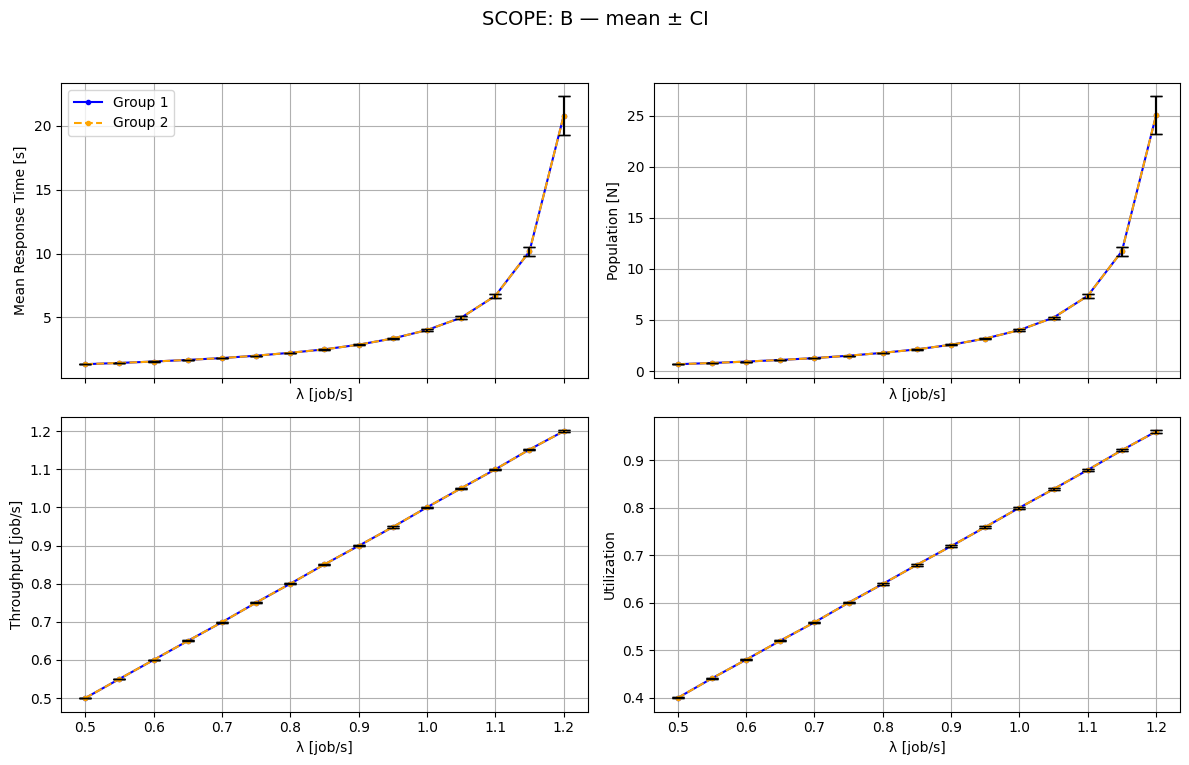

In [ ]:
df = pd.read_csv(".output_simulation/obj1_arrivals.csv")  # esempio di caricamento dati
metrics = ("MEAN_RESPONSE_TIME", "MEAN_POPULATION", "THROUGHPUT", "UTILIZATION")
results = batch_means_ci_by_scope(df, metrics=metrics, ci=0.95)
dfs = batch_means_ci_by_scope(df, ci=0.95)

plot_results_list_subplots(results, metrics=metrics, save_dir="plots_batchmeans")
#plot_overlay_subplots([results, results]) # UTILE PER CONFRONT TRA BASELINE E 2fa